# Flower Recognition with Tensorflow and MobileNet

The first thing you’d want to do is prepare your environment by importing relevant libraries and dependencies.



In [21]:
import numpy as np
import tensorflow as tf
import itertools
import os 
import shutil
import random
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

print(f"TensorFlow version {tf.__version__}")

TensorFlow version 2.15.0


# Import flowers dataset

In [22]:
import pathlib
# make working directories
data_dir = pathlib.Path('data/flower_photos')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'flower_photos.tgz',
      origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
      extract=True,
      cache_dir='.', cache_subdir='data')

Split dataset into traind and val splits

In [23]:
BATCH_SIZE = 64
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(224, 224),  # Adjust this to your desired image size
    batch_size=BATCH_SIZE  # Adjust batch size as needed
)

label_names = np.array(train_ds.class_names)
print("Label names:", label_names)

train_ds.element_spec

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.
Label names: ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Create separate test dataset from validation set

In [24]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

Take one batch and verify that your dataset is structured correctly and that the images and labels are the shape you expect

In [25]:
# get a few examples
for example_images, example_labels in train_ds.take(1):  
  print(example_images.shape)
  print(example_labels.shape)

(64, 224, 224, 3)
(64,)


In [26]:
# just checking the labels
label_names[[1,1,3,0]]

array(['dandelion', 'dandelion', 'sunflowers', 'daisy'], dtype='<U10')

Show a few images

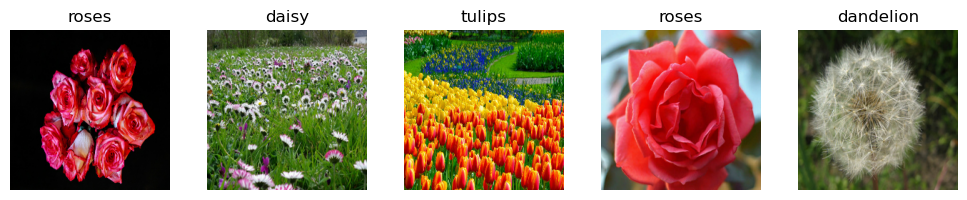

In [27]:
plt.figure(figsize=(10,2))
for images, labels in train_ds.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label_names[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 27ms/step


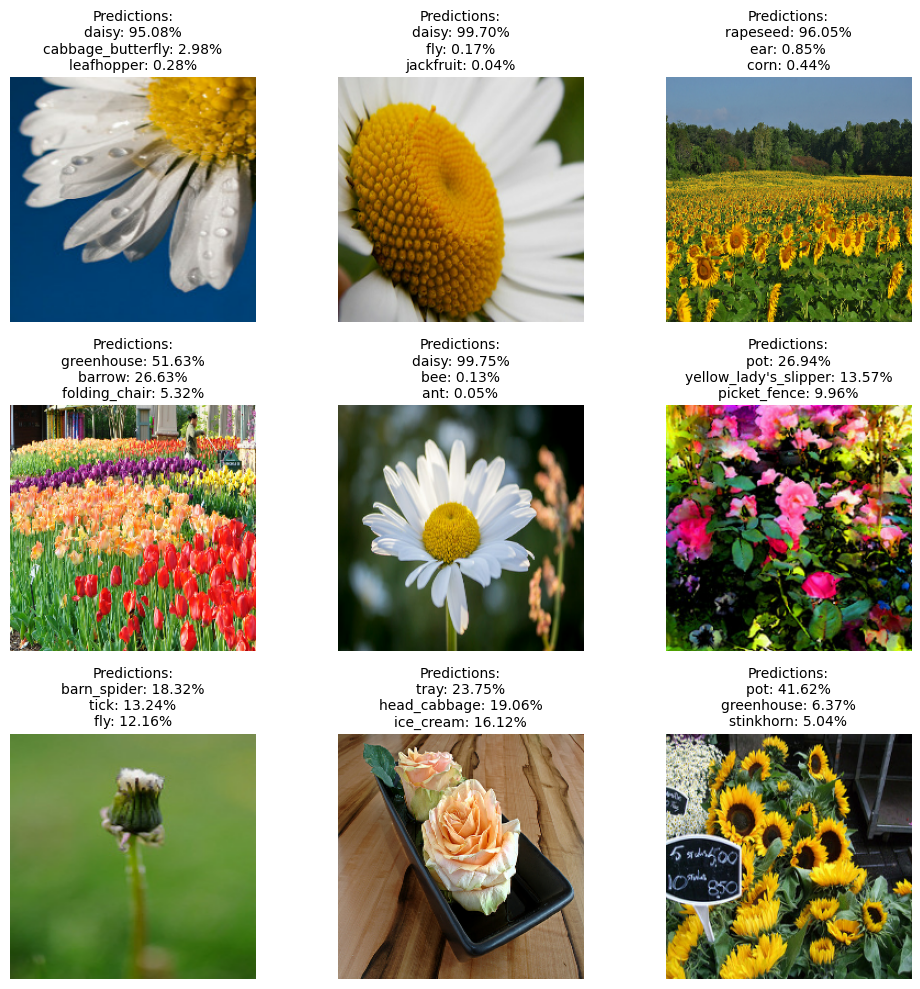

In [28]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import numpy as np
import matplotlib.pyplot as plt

# Load the MobileNet model
mobile = MobileNet(weights='imagenet', include_top=True)

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        # Extract a single image
        img = images[i]
        
        # Create a copy of the image for display
        display_img = img.numpy().astype("uint8")
        
        # Prepare image for prediction
        img_for_pred = tf.expand_dims(img, 0)
        img_for_pred = tf.image.resize(img_for_pred, (224, 224))
        img_for_pred = preprocess_input(img_for_pred)
        
        # Make prediction
        predictions = mobile.predict(img_for_pred)
        
        # Decode predictions
        results = decode_predictions(predictions, top=3)[0]
        
        # Plot image
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(display_img)
        plt.axis("off")
        
        # Create prediction text
        pred_text = "\n".join([f"{result[1]}: {result[2]*100:.2f}%" for result in results])
        plt.title(f"Predictions:\n{pred_text}", fontsize=10)

plt.tight_layout()
plt.show()

# Build and modify the MobileNet model


In [29]:
model = tf.keras.applications.MobileNet(input_shape=(224, 224, 3), weights='imagenet', include_top = False)

# Build the base MobileNet model
for layer in model.layers:
    layer.trainable = False

# Add custom layers for classification
x = model.output
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=5, activation='softmax', name='output_categorical')(x)

# Create the final model
new_model = Model(inputs=model.input, outputs=x)  # Use 'model.input' here

print(new_model.output_shape)
#new_model.summary()

# Compile the model
new_model.compile(
#                optimizer=Adam(learning_rate=0.0001),
                optimizer=tf.keras.optimizers.Adam(),
#                loss='categorical_crossentropy',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])


(None, 5)


In [30]:
# train model
import time

EPOCHS = 10

start = time.monotonic()

history = new_model.fit(
                    train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks = [tf.keras.callbacks.EarlyStopping(verbose=1, patience=2, mode='min')]
)

training_time = time.monotonic()-start
print(f"Total training time: {training_time:.2f} seconds")

Epoch 1/10


/home/muneim/anaconda3/envs/cuda/lib/python3.9/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


46/46 [==============================] - 8s 110ms/step - loss: 7.8542 - accuracy: 0.4210 - val_loss: 1.6760 - val_accuracy: 0.6000
Epoch 2/10
46/46 [==============================] - 4s 81ms/step - loss: 0.6339 - accuracy: 0.7912 - val_loss: 1.1406 - val_accuracy: 0.6371
Epoch 3/10
46/46 [==============================] - 4s 81ms/step - loss: 0.3009 - accuracy: 0.8937 - val_loss: 1.3602 - val_accuracy: 0.6829
Epoch 4/10
46/46 [==============================] - 4s 79ms/step - loss: 0.1320 - accuracy: 0.9561 - val_loss: 1.0670 - val_accuracy: 0.7286
Epoch 5/10
46/46 [==============================] - 4s 79ms/step - loss: 0.0476 - accuracy: 0.9939 - val_loss: 1.0356 - val_accuracy: 0.7171
Epoch 6/10
46/46 [==============================] - 4s 81ms/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 1.0499 - val_accuracy: 0.7057
Epoch 7/10
46/46 [==============================] - 4s 80ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 1.0668 - val_accuracy: 0.7086
Epoch 7: early stopping

Text(0, 0.5, 'Accuracy [%]')

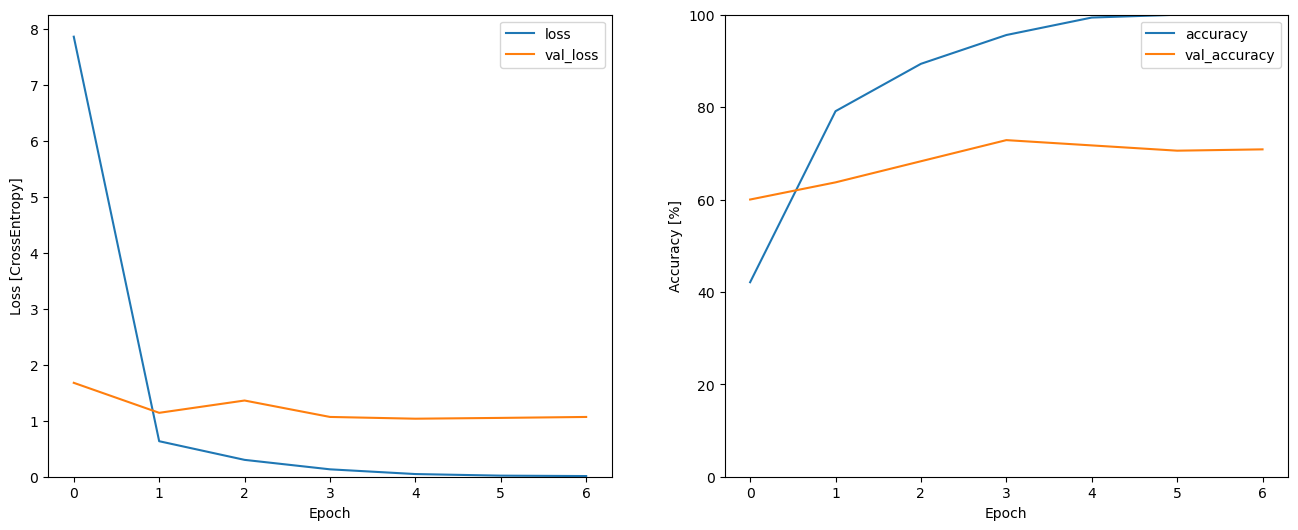

In [31]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Evaluate the model performance

In [32]:
new_model.evaluate(test_ds, return_dict=True)

6/6 [==============================] - 1s 76ms/step - loss: 0.9958 - accuracy: 0.7214


{'loss': 0.9958138465881348, 'accuracy': 0.7213541865348816}

In [33]:
y_pred = new_model.predict(test_ds)

6/6 [==============================] - 1s 74ms/step


In [34]:
y_pred = tf.argmax(y_pred, axis=1)

In [35]:
y_true = tf.concat(list(test_ds.map(lambda s,lab: lab)), axis=0)

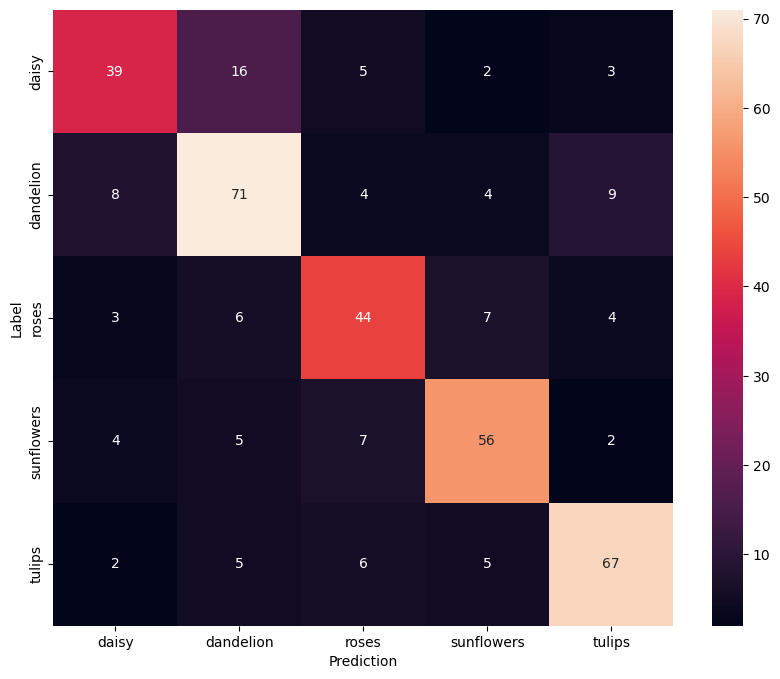

In [36]:
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [37]:
# Predict again using newly trained top layer

1/1 [==============================] - 0s 26ms/step


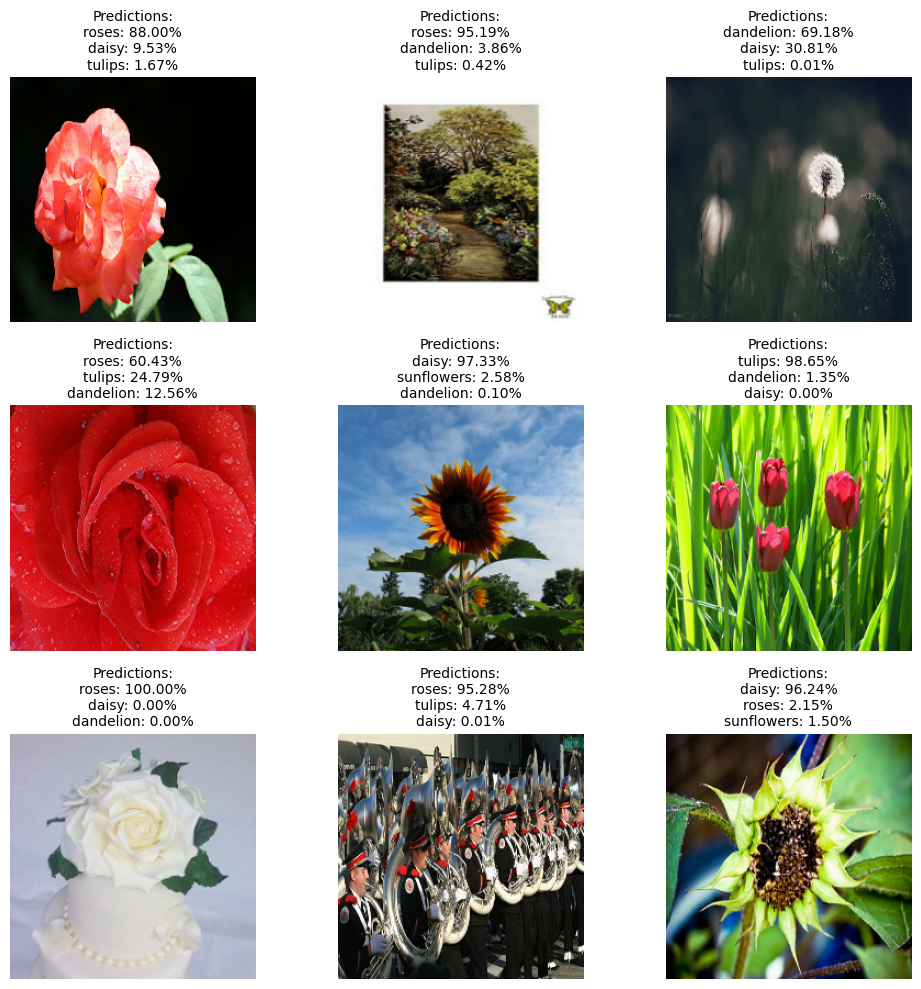

In [38]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        # Extract a single image
        img = images[i]
        
        # Create a copy of the image for display
        display_img = img.numpy().astype("uint8")
        
        # Prepare image for prediction
        img_for_pred = tf.expand_dims(img, 0)
        img_for_pred = tf.image.resize(img_for_pred, (224, 224))
        img_for_pred = preprocess_input(img_for_pred)
        
        # Make prediction
        predictions = new_model.predict(img_for_pred)
        
        # Get the top 3 predictions
        top_3 = tf.argsort(predictions[0], direction='DESCENDING')[:3]
        
        # Plot image
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(display_img)
        plt.axis("off")
        
        # Create prediction text
        pred_text = "\n".join([f"{label_names[idx]}: {predictions[0][idx]*100:.2f}%" for idx in top_3])
        plt.title(f"Predictions:\n{pred_text}", fontsize=10)

plt.tight_layout()
plt.show()